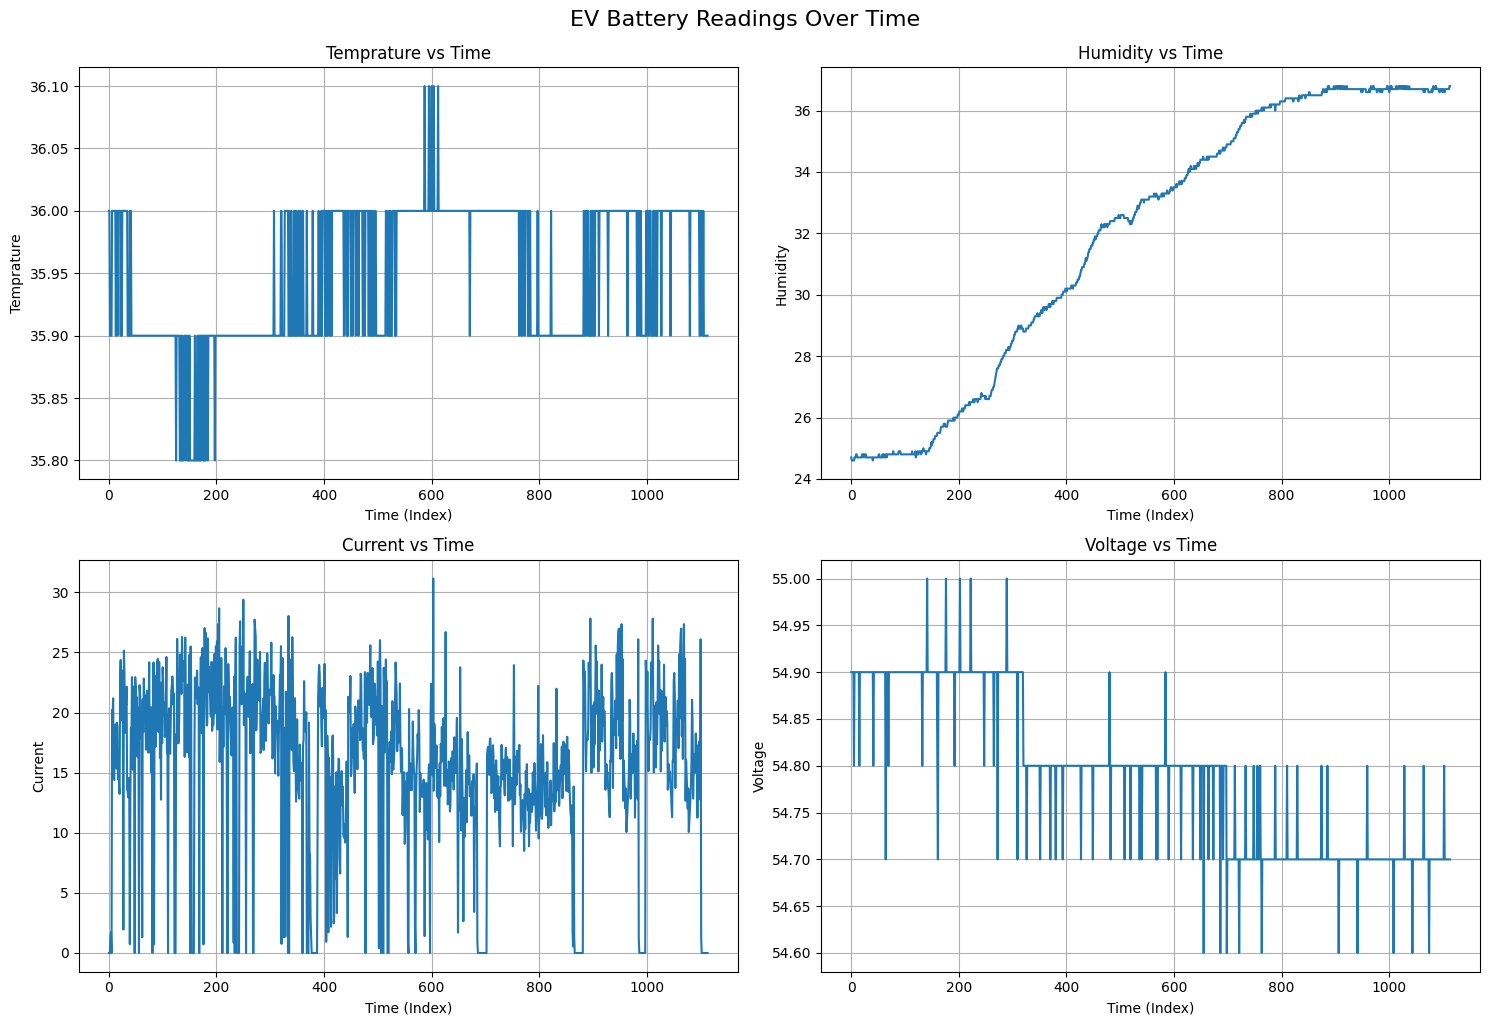

In [ ]:
# Plotting of dataset which containt normal operation
import pandas as pd
import matplotlib.pyplot as plt


# Load the CSV file from your specified path
file_path = '/content/drive/MyDrive/Colab Notebooks/Battery-readings-from-Ev.csv'
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip()

# Use index as time
time = df.index

# Plotting
plt.figure(figsize=(15, 10))

params = ['Temprature', 'Humidity', 'Current', 'Voltage']

for i, param in enumerate(params):
    plt.subplot(2, 2, i+1)
    plt.plot(time, df[param], label=param, color='tab:blue')
    plt.xlabel('Time (Index)')
    plt.ylabel(param)
    plt.title(f'{param} vs Time')
    plt.grid(True)
    plt.tight_layout()

plt.suptitle("EV Battery Readings Over Time", fontsize=16, y=1.02)
plt.show()


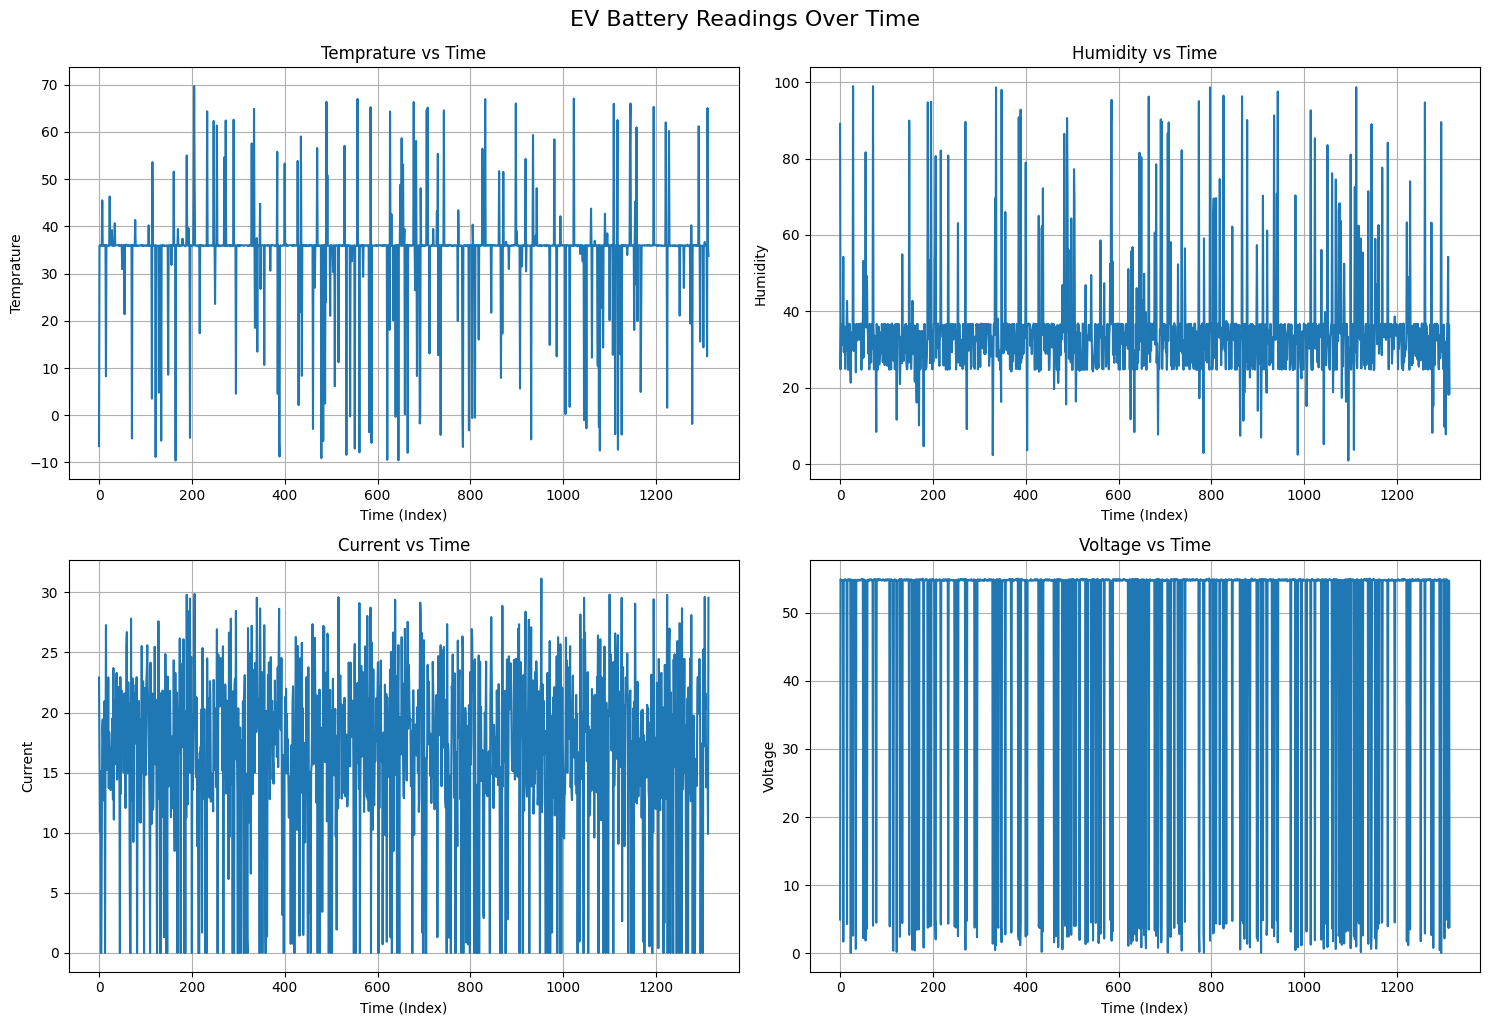

In [ ]:
# Plotting of added anomaly in the dataset to increase the anomaly detection
import pandas as pd
import matplotlib.pyplot as plt


# Load the CSV file from your specified path
file_path = '/content/drive/MyDrive/Colab Notebooks/Battery-readings-with-anomalies.csv'
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip()

# Use index as time
time = df.index

# Plotting
plt.figure(figsize=(15, 10))

params = ['Temprature', 'Humidity', 'Current', 'Voltage']

for i, param in enumerate(params):
    plt.subplot(2, 2, i+1)
    plt.plot(time, df[param], label=param, color='tab:blue')
    plt.xlabel('Time (Index)')
    plt.ylabel(param)
    plt.title(f'{param} vs Time')
    plt.grid(True)
    plt.tight_layout()

plt.suptitle("EV Battery Readings Over Time", fontsize=16, y=1.02)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
import firebase_admin
from firebase_admin import credentials, db
import time

# Load and clean data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Battery-readings-with-anomalies.csv')
df.columns = df.columns.str.strip()
features = ['Temprature', 'Humidity', 'Current', 'Voltage', 'anomaly']
df = df[features]

# Train Isolation Forest
X = df[features[:-1]]  # Exclude the 'anomaly' column for training
y_true = df['anomaly']
model = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)  # Adjust contamination
y_pred = model.fit_predict(X)
y_pred = np.where(y_pred == -1, 1, 0)  # Convert to 1=anomaly, 0=normal

# Evaluate
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Evaluation Metrics:
MSE: 0.0167
RMSE: 0.1294
MAE: 0.0167
R²: 0.8703
Precision: 0.9541
Recall: 0.9350
F1 Score: 0.9444


In [ ]:
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import time

# Initialize Firebase
if not firebase_admin._apps:
    cred = credentials.Certificate("/content/drive/MyDrive/Colab Notebooks/firebase-key.json")
    firebase_admin.initialize_app(cred, {
        "databaseURL": "https://ev-battery-monitoring-system-default-rtdb.asia-southeast1.firebasedatabase.app/"
    })

# Real-time Alert System
class AlertSystem:
    def __init__(self, model):
        self.model = model
        self.prev = {}

    def check_alerts(self, data):
        temp, hum, curr, volt = data['Temprature'], data['Humidity'], data['Current'], data['Voltage']
        alerts = []

        input_df = pd.DataFrame([data])
        ml_prediction = self.model.predict(input_df)[0]

        if curr > 10 and 'Voltage' in self.prev and (self.prev['Voltage'] - volt) > 5:
            alerts.append("Red Alert: Possible short circuit detected!")
        if temp < 0 or temp > 45:
            alerts.append("Orange Alert: Temperature out of safe range!")
        if hum < 20 or hum > 60:
            alerts.append("Orange Alert: Humidity out of safe range!")
        if 'Voltage' in self.prev and abs(self.prev['Voltage'] - volt) > 1:
            alerts.append("Orange Alert: Sudden Voltage Drop!")
        if 'Temprature' in self.prev and abs(self.prev['Temprature'] - temp) > 1:
            alerts.append("Orange Alert: Sudden Temperature Change!")
        if 'Humidity' in self.prev and abs(self.prev['Humidity'] - hum) > 5:
            alerts.append("Orange Alert: Sudden Humidity Change!")

        self.prev = data
        return alerts, "Anomaly Detected!" if alerts else "Normal Operation."

# Replace 'model' with your trained ML model instance
alert_system = AlertSystem(model)
last_status = None
last_alerts = []

# Monitoring loop
while True:
    try:
        ref = db.reference("/sensor")
        data = ref.get()

        if data:
            reading = {
                "Temprature": float(data.get("temperature", 0)),
                "Humidity": float(data.get("humidity", 0)),
                "Current": float(data.get("current", 0)),
                "Voltage": float(data.get("voltage", 0))
            }

            alerts, status = alert_system.check_alerts(reading)

            # Always update current alerts
            db.reference("/alerts").set({
                "alerts": alerts,
                "status": status,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
            })

            # Always push anomalies to history, even if repeated
            if status == "Anomaly Detected!":
                db.reference("/history").push({
                    "alerts": alerts,
                    "status": status,
                    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
                })

            last_alerts = alerts
            last_status = status


            print(f"{time.strftime('%H:%M:%S')} | Checked: {reading} -> {status}")
            if alerts:
                print("⚠️", alerts)

        time.sleep(2)

    except Exception as e:
        print("Monitoring error:", e)
        time.sleep(5)


17:16:55 | Checked: {'Temprature': 34.2, 'Humidity': 51.7, 'Current': 14.75, 'Voltage': 58.7} -> Normal Operation.


KeyboardInterrupt: 